In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>\n{css}\n</style>"))

# فصل ۱ — مقدمه‌ای بر یادگیری ماشین  
## درس ۲: انواع یادگیری ماشین (نظارتی، بدون‌ناظر، نیمه‌نظارتی، یادگیری تقویتی)

این نوت‌بوک بخشی از **دورهٔ مقدماتی یادگیری ماشین** است. در این درس، یک درک عملی و مهندسی از پارادایم‌های اصلی یادگیری به‌دست می‌آورید:

- **یادگیری نظارتی** (طبقه‌بندی و رگرسیون)
- **یادگیری بدون‌ناظر** (خوشه‌بندی و کشف بازنمایی)
- **یادگیری نیمه‌نظارتی** (یادگیری با تعداد کم دادهٔ برچسب‌دار و تعداد زیاد دادهٔ بدون برچسب)
- **یادگیری تقویتی** (یادگیری از تعامل و پاداش‌های با تأخیر)

فراتر از تعریف‌ها، به یک سؤال مهم‌تر پاسخ می‌دهیم: **چه زمانی باید هر پارادایم را انتخاب کنیم و چه حالت‌های شکست رایج را باید پیش‌بینی کنیم؟**

---

### اهداف یادگیری

در پایان این درس باید بتوانید:

1. یک مسئلهٔ واقعی را به پارادایم و نوع وظیفهٔ مناسب نگاشت کنید.
2. نیازمندی‌های داده (برچسب‌ها، بازخورد، ساختار) را برای هر پارادایم تشخیص دهید.
3. برای هر پارادایم، مدل‌های پایه را در پایتون پیاده‌سازی کرده و خروجی‌ها را تفسیر کنید.
4. دام‌های رایج را بشناسید: نشت داده، ارزیابی اشتباه، هم‌بستگی‌های کاذب، و «هک‌کردن پاداش».
5. با آزمایش‌های کوچک و بازتولیدپذیر، شهود بسازید و با چند دیتاست مختلف کار کنید.

---

### نمادگذاری مورد استفاده در این نوت‌بوک

از نمادگذاری استاندارد یادگیری ماشین استفاده می‌کنیم:

- دیتاست: $\{(x_i, y_i)\}_{i=1}^n$
- مدل: $f_\theta(x)$ با پارامترهای $\theta$
- تابع خطا: $\ell(y, f_\theta(x))$
- ریسک تجربی (هدف آموزش):

$$
\hat{R}(\theta) = \frac{1}{n}\sum_{i=1}^n \ell\left(y_i, f_\theta(x_i)\right)
$$

یک الگوریتم یادگیری، $\hat{\theta}$ را طوری انتخاب می‌کند که (تقریباً) $\hat{R}(\theta)$ را کمینه کند؛ معمولاً همراه با رگولاریزیشن.

---

### دیتاست‌های مورد استفاده (به‌صورت تصادفی برای این درس انتخاب شده‌اند)

برای جلوگیری از «بیش‌برازش به یک دیتاست» (یعنی آموزش‌دادن دیتاست به‌جای مفهوم)، در این درس از چند دیتاست از مخزن شما استفاده می‌کنیم:

- **طبقه‌بندی:** `iris.csv`
- **رگرسیون:** `house-prices.csv`
- **خوشه‌بندی / بدون‌ناظر:** `airports.csv` و `hw_200.csv`

تمام مسیرها **نسبی** به محل نوت‌بوک در مخزن شما هستند، مانند `../../../Datasets/Classification/iris.csv`.

## ۰. یک «مدل ذهنی» برای انواع یادگیری ماشین

یک روش سریع برای به‌خاطر سپردن پارادایم‌ها این است که به این فکر کنید **چه چیزی حلقه را می‌بندد**:

- **نظارتی:** حلقه با *برچسب‌ها* $y$ بسته می‌شود.
- **بدون‌ناظر:** حلقه با *ساختار* (شباهت، چگالی، بازسازی) بسته می‌شود.
- **نیمه‌نظارتی:** حلقه با *برچسب* به‌علاوهٔ *ساختار* در $p(x)$ بسته می‌شود.
- **تقویتی:** حلقه با *پاداش* و *دینامیک محیط* بسته می‌شود.

یک لنز مفید دیگر این است که **چه کسی داده را کنترل می‌کند**:

- در نظارتی/بدون‌ناظر/نیمه‌نظارتی معمولاً دیتاست به‌صورت آفلاین جمع‌آوری شده است.
- در RL سیاست عامل تعیین می‌کند چه داده‌ای دیده شود؛ این می‌تواند حلقه‌های بازخوردی ایجاد کند.

---

## ۲.۱ یادگیری نظارتی با جزئیات بیشتر

### دو وظیفهٔ اصلی در یادگیری نظارتی

**طبقه‌بندی** پاسخ می‌دهد: «کدام دسته؟»  
مثال‌ها: اسپم یا غیر اسپم؛ نوع بیماری؛ ریزش مشتری.

**رگرسیون** پاسخ می‌دهد: «چقدر؟»  
مثال‌ها: قیمت، تقاضا، زمان تا خرابی.

### فرض‌های پنهان در «نظارتی»
یادگیری نظارتی فرض می‌کند می‌توانید هدف $y$ را تعریف کنید و برچسب‌های تاریخی نمایندهٔ چیزی هستند که در آینده می‌خواهید پیش‌بینی کنید. این فرض زیر شرایط زیر می‌شکند:

- تغییر مفهوم (concept drift)
- خطای برچسب (اختلاف نظر انسان‌ها، خطای اندازه‌گیری)
- برچسب‌های جانشین (آنچه قابل اندازه‌گیری است دقیقاً همان هدف واقعی نیست)

### انضباط ارزیابی
یک قانون عملی: *ارزیابی باید شبیه استقرار باشد.*  
اشتباه‌های رایج:

- Fit کردن پیش‌پردازش روی کل داده قبل از split (نشت داده)
- استفاده از split تصادفی برای سری‌زمانی (نشت آینده به گذشته)
- تنظیم هایپرپارامترها روی دادهٔ آزمون

---

## ۴.۱ یادگیری بدون‌ناظر با جزئیات بیشتر

هدف‌های بدون‌ناظر یکتا نیستند. دو خانوادهٔ رایج:

1. **خوشه‌بندی:** تقسیم داده به گروه‌هایی با شباهت درون‌گروهی بالا.
2. **یادگیری بازنمایی:** نگاشت $x \mapsto z$ که $z$ کم‌بُعد است اما ساختار مهم را حفظ می‌کند.

چون بدون برچسب «پاسخ صحیح» یگانه‌ای نداریم، ارزیابی معمولاً از این‌ها استفاده می‌کند:
- معیارهای داخلی (سیلوئت، Davies–Bouldin)
- پایداری تحت نمونه‌گیری مجدد
- سودمندی پایین‌دستی (آیا خوشه‌ها به تصمیم یا مدل نظارتی کمک می‌کنند؟)

---

## ۵.۱ یادگیری نیمه‌نظارتی: چرا می‌تواند کمک کند؟

نیمه‌نظارتی معمولاً مفید است وقتی:
- دادهٔ بدون‌برچسب زیاد و مشابه تولید است
- مرز کلاس‌ها در نواحی کم‌چگالی قرار دارد («فرض خوشه‌ای»)
- برچسب‌گذاری گران است (پزشکی، حقوقی، برچسب‌گذاری تخصصی)

و ممکن است شکست بخورد وقتی:
- دادهٔ بدون‌برچسب از توزیع متفاوتی بیاید
- فرض خوشه‌ای برقرار نباشد
- شبه‌برچسب‌ها خطاهای اولیه را تقویت کنند

---

## ۶.۱ یادگیری تقویتی: مفاهیم کلیدی که باید درونی کنید

سه دشواری متمایز در RL:

1. **انتساب اعتبار:** پاداش دیرتر از کنش‌هایی می‌آید که باعث آن شده‌اند.
2. **اکتشاف:** برای یادگیری باید امتحان کنید، اما امتحان‌کردن می‌تواند پرهزینه باشد.
3. **دادهٔ غیر i.i.d.:** توزیع داده با تغییر سیاست عوض می‌شود.

یک مقایسهٔ مفهومی مفید:

- نظارتی ریسک تجربی $\hat{R}(\theta)$ را روی دیتاست ثابت کمینه می‌کند.
- RL امید ریاضی بازگشت $\mathbb{E}[G_0]$ را تحت سیاست و دینامیک محیط بیشینه می‌کند.

---

## جدول خلاصه

| پارادایم | دادهٔ موجود | هدف | خروجی‌های رایج | معیارهای رایج |
|---|---|---|---|---|
| نظارتی | $(x, y)$ | پیش‌بینی $y$ | $\hat{y}$ | دقت، F1، MAE، RMSE |
| بدون‌ناظر | فقط $x$ | کشف ساختار | خوشه‌ها، امبدینگ | سیلوئت، پایداری، سودمندی |
| نیمه‌نظارتی | برچسب کم + $x$ زیاد | پیش‌بینی بهتر $y$ | $\hat{y}$ بهتر | مانند نظارتی |
| تقویتی | $(s,a,r,s')$ | بیشینه‌سازی پاداش بلندمدت | سیاست، $Q(s,a)$ | بازگشت میانگین، regret |

در ادامهٔ نوت‌بوک، این مفاهیم را پیاده‌سازی و بصری‌سازی می‌کنیم.

## ۱. یک طبقه‌بندی عملی: تفاوت اصلی پارادایم‌های یادگیری چیست؟

یک راه مفید برای طبقه‌بندی پارادایم‌های یادگیری این است که به سه سؤال پاسخ بدهیم:

1. **چه سیگنال بازخوردی داریم؟**  
   - برچسب‌های واقعی $y$ (نظارتی)  
   - بدون برچسب؛ فقط ساختار در $x$ (بدون‌ناظر)  
   - تعداد کم برچسب + تعداد زیاد دادهٔ بدون‌برچسب (نیمه‌نظارتی)  
   - پاداش از تعامل (تقویتی)

2. **داده چگونه تولید می‌شود؟**  
   - دیتاست ثابت که به‌صورت آفلاین جمع‌آوری شده (نظارتی / بدون‌ناظر / نیمه‌نظارتی)  
   - فرایند تصمیم‌گیری دنباله‌ای که در آن کنش‌ها بر حالت‌های بعدی اثر می‌گذارند (تقویتی)

3. **هدف چیست؟**  
   - پیش‌بینی یک خروجی (طبقه‌بندی/رگرسیون)  
   - کشف ساختار یا فشرده‌سازی اطلاعات (خوشه‌بندی/بازنمایی)  
   - استفاده از دادهٔ بدون‌برچسب برای بهبود پیش‌بینی  
   - بیشینه‌کردن پاداش بلندمدت تحت عدم‌قطعیت

### ۱.۱ یادگیری نظارتی
زوج‌های $(x, y)$ را مشاهده می‌کنید و یک نگاشت $f: x \mapsto y$ یاد می‌گیرید.

- طبقه‌بندی: $y$ گسسته است.
- رگرسیون: $y$ پیوسته است.

هدف رایج:

$$
\min_\theta \ \frac{1}{n}\sum_{i=1}^n \ell\left(y_i, f_\theta(x_i)\right) + \lambda \Omega(\theta)
$$

### ۱.۲ یادگیری بدون‌ناظر
فقط $x$ را دارید و می‌خواهید ساختار را پیدا کنید: خوشه‌ها، منیفولدها، چگالی، ناهنجاری‌ها.

### ۱.۳ یادگیری نیمه‌نظارتی
یک مجموعهٔ کوچک برچسب‌دار و یک مجموعهٔ بزرگ بدون‌برچسب دارید. فرض کلیدی این است که **دادهٔ بدون‌برچسب دربارهٔ توزیع ورودی** $p(x)$ اطلاعاتی دارد که برای یادگیری $p(y|x)$ مفید است.

### ۱.۴ یادگیری تقویتی (RL)
عامل در طول زمان با محیط تعامل می‌کند:

- حالت $s_t$
- کنش $a_t$
- پاداش $r_t$
- حالت بعدی $s_{t+1}$

هدف: بیشینه‌کردن بازگشت تنزیل‌شده

$$
G_t = \sum_{k=0}^{\infty} \gamma^k r_{t+k}
$$

در ادامهٔ نوت‌بوک، این پارادایم‌ها را با کد پیاده‌سازی می‌کنید و نتایج را تفسیر خواهید کرد.

In [2]:
# Common imports and reproducibility
import numpy as np
import pandas as pd

from pathlib import Path

np.random.seed(7)

DATASETS = Path("../../../Datasets")
print("Datasets root:", DATASETS)

Datasets root: ../../../Datasets


## ۲. بارگذاری دیتاست‌ها از مخزن (مسیرهای نسبی)

بارگذاری می‌کنیم:

- طبقه‌بندی: `../../../Datasets/Classification/iris.csv`
- رگرسیون: `../../../Datasets/Regression/house-prices.csv`
- خوشه‌بندی: `../../../Datasets/Clustering/airports.csv` و `../../../Datasets/Clustering/hw_200.csv`

In [3]:
iris_path = DATASETS / "Classification" / "iris.csv"
house_path = DATASETS / "Regression" / "house-prices.csv"
airports_path = DATASETS / "Clustering" / "airports.csv"
hw_path = DATASETS / "Clustering" / "hw_200.csv"

iris_df = pd.read_csv(iris_path)
house_df = pd.read_csv(house_path)
airports_df = pd.read_csv(airports_path)
hw_df = pd.read_csv(hw_path)

print("iris_df shape:", iris_df.shape)
print("house_df shape:", house_df.shape)
print("airports_df shape:", airports_df.shape)
print("hw_df shape:", hw_df.shape)

iris_df.head()

iris_df shape: (150, 5)
house_df shape: (305, 8)
airports_df shape: (120, 12)
hw_df shape: (200, 3)


,sepal_length,sepal_width,petal_length,petal_width,classification
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## ۳. یادگیری نظارتی

### ۳.۱ مثال طبقه‌بندی (Iris)

یک خط پایهٔ **رگرسیون لجستیک چندکلاسه** را با تقسیم آموزش/آزمون و پایپ‌لاین (برای جلوگیری از نشت داده) آموزش می‌دهیم.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X = iris_df.drop(columns=["classification"])
y = iris_df["classification"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7, stratify=y
)

clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=300, multi_class="auto"))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

Confusion matrix:
 [[13  0  0]
 [ 0 12  1]
 [ 0  0 12]]

Classification report:

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        13
Iris-versicolor       1.00      0.92      0.96        13
 Iris-virginica       0.92      1.00      0.96        12

       accuracy                           0.97        38
      macro avg       0.97      0.97      0.97        38
   weighted avg       0.98      0.97      0.97        38



### ۳.۲ تفسیر نتایج طبقه‌بندی

تمرکز کنید روی:
- الگوی خطاها
- Precision/Recall هر کلاس
- هم‌راستایی معیار با هزینهٔ کاربرد

همچنین با یک درخت تصمیم ساده مقایسه می‌کنیم تا انعطاف‌پذیری مدل در برابر واریانس روشن شود.

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

tree = DecisionTreeClassifier(max_depth=3, random_state=7)
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)

print("Decision Tree accuracy:", accuracy_score(y_test, tree_pred))
print("\nClassification report:\n")
print(classification_report(y_test, tree_pred))

Decision Tree accuracy: 0.973684

Classification report:

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        13
Iris-versicolor       1.00      0.92      0.96        13
 Iris-virginica       0.92      1.00      0.96        12

       accuracy                           0.97        38
      macro avg       0.97      0.97      0.97        38
   weighted avg       0.98      0.97      0.97        38



### ۳.۳ اعتبارسنجی متقابل (چرا تقسیم آموزش/آزمون همیشه کافی نیست)

یک تقسیم آموزش/آزمون می‌تواند گمراه‌کننده باشد (واریانس بالا). اعتبارسنجی متقابل K-fold میانگین عملکرد را روی چند تقسیم تخمین می‌زند.

از **۵-فولد لایه‌بندی‌شده** استفاده می‌کنیم چون Iris یک دیتاست طبقه‌بندی است.

تفسیر کلیدی:
- میانگین دقت CV یک برآورد از عملکرد مورد انتظار روی نمونه‌های آینده است.
- انحراف معیار نشان‌دهندهٔ حساسیت به نویز نمونه‌گیری (کمبود داده) است.

In [6]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
cv_scores = cross_val_score(clf, X, y, cv=skf, scoring="accuracy")

print(f"5-fold CV accuracy: mean={cv_scores.mean():.3f}, std={cv_scores.std():.3f}")
pd.DataFrame({"fold": range(1, 6), "accuracy": cv_scores})

5-fold CV accuracy: mean=0.960, std=0.033


,fold,accuracy
0,1,0.966667
1,2,0.966667
2,3,0.966667
3,4,0.900000
4,5,1.000000


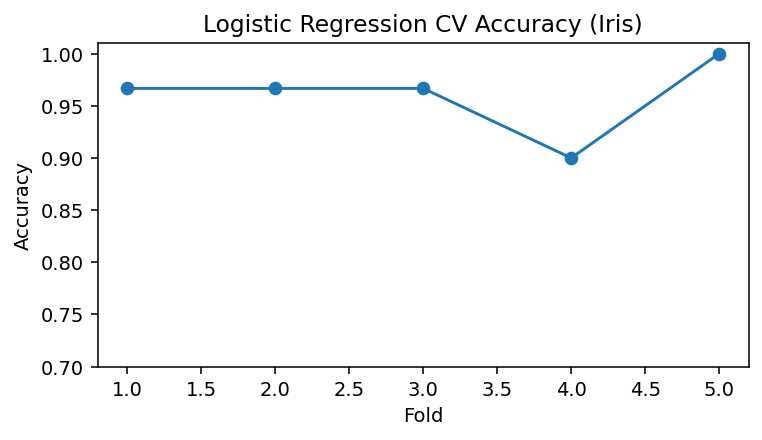

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
plt.plot(range(1, 6), cv_scores, marker="o")
plt.ylim(0.7, 1.01)
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Logistic Regression CV Accuracy (Iris)")
plt.show()

### ۳.۳ مثال رگرسیون (قیمت خانه)

از پایپ‌لاین با `OneHotEncoder` برای متغیرهای دسته‌ای استفاده می‌کنیم و با MAE، RMSE و $R^2$ ارزیابی می‌کنیم.

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

target = "Price"
X = house_df.drop(columns=[target])
y = house_df[target]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7
)

reg = Pipeline(steps=[
    ("prep", preprocess),
    ("model", Ridge(alpha=1.0, random_state=7))
])

reg.fit(X_train, y_train)
pred = reg.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)

print(f"MAE:  {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")
print(f"R^2:  {r2:.3f}")

pd.DataFrame({"y_true": y_test.values[:10], "y_pred": pred[:10]}).head(10)

MAE:  14,001
RMSE: 20,122
R^2:  0.850


,y_true,y_pred
0,250331,251140.847580
1,161453,174420.121781
2,174784,154417.415767
3,297167,287801.723575
4,161957,155635.766227
5,246077,261007.713429
6,244181,251123.608364
7,294899,289332.616107
8,175539,183403.195662
9,206644,180469.420051


## ۴. یادگیری بدون‌ناظر

### ۴.۱ مثال خوشه‌بندی: فرودگاه‌ها بر اساس موقعیت و ارتفاع

K-Means را اجرا می‌کنیم و با سیلوئت (یک معیار اعتبارسنجی داخلی) ارزیابی می‌کنیم.

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

feat_cols = ["latitude_deg", "longitude_deg", "elevation_ft"]
A = airports_df[feat_cols].copy().dropna()

A_scaled = StandardScaler().fit_transform(A)

k = 4
kmeans = KMeans(n_clusters=k, random_state=7, n_init=10)
labels = kmeans.fit_predict(A_scaled)

sil = silhouette_score(A_scaled, labels)
print(f"KMeans k={k} silhouette: {sil:.3f}")

airports_clustered = airports_df.loc[A.index, feat_cols].copy()
airports_clustered["cluster"] = labels
airports_clustered.groupby("cluster")[feat_cols].mean().round(2)

KMeans k=4 silhouette: 0.320


,latitude_deg,longitude_deg,elevation_ft
cluster,,,
0,33.63,-97.93,6624.77
1,38.56,-74.02,3987.61
2,45.50,-110.78,2561.42
3,30.57,-104.51,2153.70


### ۴.۲ انتخاب تعداد خوشه‌ها: بررسی سیلوئت برای $k$های مختلف

یک سؤال رایج در بدون‌ناظر: «$k$ مناسب چیست؟»  
سیلوئت یک معیار *داخلی* است که فشردگی درون‌خوشه‌ای را با جدایی بین‌خوشه‌ای مقایسه می‌کند.

تفسیر:
- مقدار بزرگ‌تر بهتر است، اما حقیقت مطلق نیست
- پایداری و معنای دامنه‌ای را بررسی کنید (خوشه‌ها باید قابل استفاده باشند)

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = range(2, 9)
sil_scores = []
for k in k_values:
    labels = KMeans(n_clusters=k, random_state=7, n_init=10).fit_predict(A_scaled)
    sil_scores.append(silhouette_score(A_scaled, labels))

sil_df = pd.DataFrame({"k": list(k_values), "silhouette": np.round(sil_scores, 3)})
sil_df

,k,silhouette
0,2,0.267
1,3,0.293
2,4,0.320
3,5,0.321
4,6,0.338
5,7,0.331
6,8,0.307


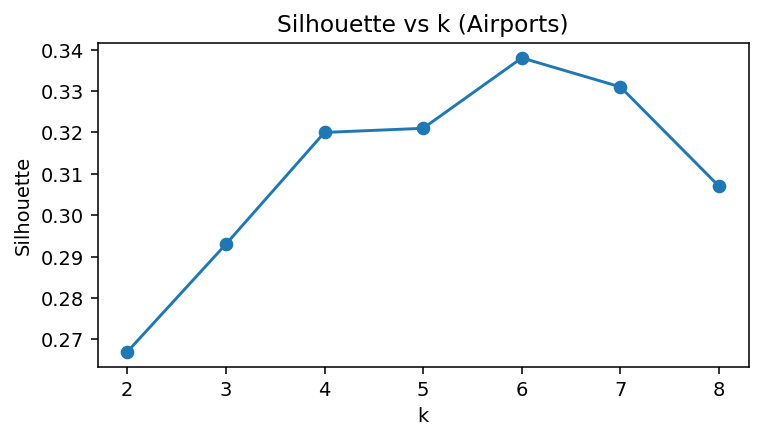

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
plt.plot(sil_df["k"], sil_df["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.title("Silhouette vs k (Airports)")
plt.show()

### ۴.۲ یک مثال خوشه‌بندی دیگر: قد/وزن (hw_200)

خوشه‌بندی را روی یک دیتاست دیگر تکرار می‌کنیم تا نشان دهیم نتیجهٔ خوشه‌بندی به مقیاس و معنای ویژگی‌ها شدیداً وابسته است.

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

B = hw_df[["Height(Inches)", "Weight(Pounds)"]].dropna()
B_scaled = StandardScaler().fit_transform(B)

k = 3
labels_hw = KMeans(n_clusters=k, random_state=7, n_init=10).fit_predict(B_scaled)
sil_hw = silhouette_score(B_scaled, labels_hw)
print(f"hw_200 KMeans k={k} silhouette: {sil_hw:.3f}")

summary = B.copy()
summary["cluster"] = labels_hw
summary.groupby("cluster").agg(["mean", "std"]).round(2)

hw_200 KMeans k=3 silhouette: 0.353


Height(Inches)       Weight(Pounds)      
                  mean   std           mean   std
cluster                                          
0                68.83  1.49         161.83  8.47
1                64.27  1.70         154.49  9.27
2                71.04  2.66         182.54  7.71

### ۴.۳ مقیاس‌گذاری خیلی مهم است

روش‌های مبتنی بر فاصله (K-Means، kNN، بسیاری از کرنل‌ها) به مقیاس ویژگی‌ها بسیار حساس هستند.
اگر یک ویژگی دامنهٔ عددی بزرگ‌تری داشته باشد، فاصلهٔ اقلیدسی را غالب می‌کند.

در ادامه سیلوئت را **با** و **بدون** مقیاس‌گذاری مقایسه می‌کنیم.

In [13]:
# Compare KMeans with and without scaling
labels_no_scale = KMeans(n_clusters=3, random_state=7, n_init=10).fit_predict(B.values)
sil_no_scale = silhouette_score(B.values, labels_no_scale)

labels_scaled = KMeans(n_clusters=3, random_state=7, n_init=10).fit_predict(B_scaled)
sil_scaled = silhouette_score(B_scaled, labels_scaled)

scale_cmp = pd.DataFrame({
    "setting": ["No scaling", "StandardScaler"],
    "silhouette": [round(sil_no_scale, 3), round(sil_scaled, 3)]
})
print("Impact of feature scaling on KMeans (hw_200):")
scale_cmp

Impact of feature scaling on KMeans (hw_200):
       setting  silhouette
    No scaling       0.488
StandardScaler       0.353


,setting,silhouette
0,No scaling,0.488
1,StandardScaler,0.353


## ۵. یادگیری نیمه‌نظارتی

سناریوی «برچسب کم + دادهٔ بدون‌برچسب زیاد» را با Iris شبیه‌سازی می‌کنیم و LabelSpreading را با یک خط پایهٔ نظارتی (فقط روی بخش برچسب‌دار) مقایسه می‌کنیم.

In [14]:
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

X = iris_df.drop(columns=["classification"]).values
y = iris_df["classification"].values

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7, stratify=y
)

rng = np.random.default_rng(7)
n_train = len(y_train_full)
labeled_fraction = 0.10
labeled_idx = rng.choice(np.arange(n_train), size=max(1, int(n_train*labeled_fraction)), replace=False)

y_train_semi = np.array(["-1"]*n_train, dtype=object)
y_train_semi[labeled_idx] = y_train_full[labeled_idx]

classes = np.unique(y_train_full)
class_to_int = {c:i for i,c in enumerate(classes)}
y_train_int = np.array([class_to_int.get(lbl, -1) for lbl in y_train_semi], dtype=int)

model = LabelSpreading(kernel="rbf", gamma=20)
model.fit(X_train_full, y_train_int)

y_pred_int = model.predict(X_test)
int_to_class = {i:c for c,i in class_to_int.items()}
y_pred = np.array([int_to_class[i] for i in y_pred_int], dtype=object)

acc = accuracy_score(y_test, y_pred)
print(f"Semi-supervised (LabelSpreading) test accuracy: {acc:.3f}")

from sklearn.neighbors import KNeighborsClassifier
X_labeled = X_train_full[labeled_idx]
y_labeled = y_train_full[labeled_idx]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_labeled, y_labeled)
knn_pred = knn.predict(X_test)

acc_knn = accuracy_score(y_test, knn_pred)
print(f"Supervised baseline on only {len(labeled_idx)} labeled points (kNN) accuracy: {acc_knn:.3f}")

Semi-supervised (LabelSpreading) test accuracy: 0.921
Supervised baseline on only 11 labeled points (kNN) accuracy: 0.684


### ۵.۱ منحنی کمبود برچسب: چند برچسب لازم دارید؟

یک روش عملی برای فهم ارزش نیمه‌نظارتی، رسم یک منحنی است:
- محور x: سهم برچسب‌دار
- محور y: دقت آزمون

اگر نیمه‌نظارتی کمک کند، باید در سهم‌های برچسب‌دار کم، افزایش معنی‌دار دقت ببینید.

In [15]:
# Accuracy vs labeled fraction
fractions = [0.05, 0.10, 0.20, 0.30]
rows = []
for f in fractions:
    n_train = len(y_train_full)
    rng = np.random.default_rng(7)
    labeled_idx = rng.choice(np.arange(n_train), size=max(1, int(n_train*f)), replace=False)

    y_train_semi = np.array(["-1"]*n_train, dtype=object)
    y_train_semi[labeled_idx] = y_train_full[labeled_idx]

    classes = np.unique(y_train_full)
    class_to_int = {c:i for i,c in enumerate(classes)}
    y_train_int = np.array([class_to_int.get(lbl, -1) for lbl in y_train_semi], dtype=int)

    ls = LabelSpreading(kernel="rbf", gamma=20)
    ls.fit(X_train_full, y_train_int)
    y_pred_int = ls.predict(X_test)
    int_to_class = {i:c for c,i in class_to_int.items()}
    y_pred = np.array([int_to_class[i] for i in y_pred_int], dtype=object)
    acc_ls = accuracy_score(y_test, y_pred)

    # baseline: only labeled points
    X_labeled = X_train_full[labeled_idx]
    y_labeled = y_train_full[labeled_idx]
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_labeled, y_labeled)
    acc_knn = accuracy_score(y_test, knn.predict(X_test))

    rows.append((f, len(labeled_idx), round(acc_ls, 3), round(acc_knn, 3)))

semi_sweep = pd.DataFrame(rows, columns=["labeled_fraction", "n_labeled", "LabelSpreading_acc", "kNN_labeled_only_acc"])
print("Semi-supervised accuracy vs labeled fraction (Iris):")
semi_sweep

Semi-supervised accuracy vs labeled fraction (Iris):
 labeled_fraction  n_labeled  LabelSpreading_acc  kNN_labeled_only_acc
             0.05          5               0.974                 0.342
             0.10         11               0.921                 0.684
             0.20         22               0.921                 0.895
             0.30         33               0.974                 0.974


,labeled_fraction,n_labeled,LabelSpreading_acc,kNN_labeled_only_acc
0,0.05,5,0.974,0.342
1,0.10,11,0.921,0.684
2,0.20,22,0.921,0.895
3,0.30,33,0.974,0.974


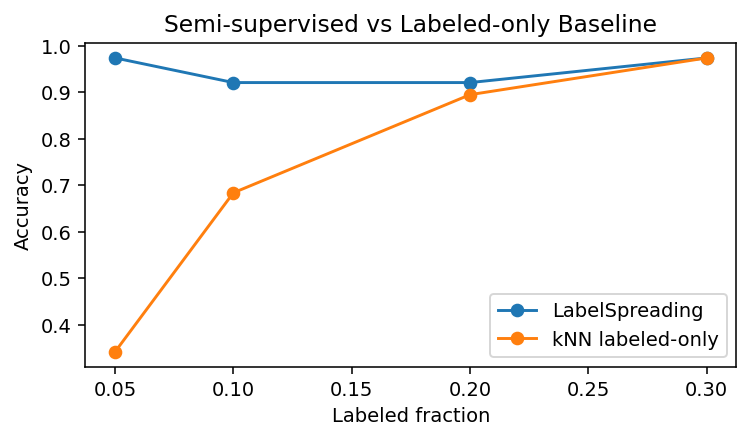

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
plt.plot(semi_sweep["labeled_fraction"], semi_sweep["LabelSpreading_acc"], marker="o", label="LabelSpreading")
plt.plot(semi_sweep["labeled_fraction"], semi_sweep["kNN_labeled_only_acc"], marker="o", label="kNN labeled-only")
plt.xlabel("Labeled fraction")
plt.ylabel("Accuracy")
plt.title("Semi-supervised vs Labeled-only Baseline")
plt.legend()
plt.show()

## ۶. یادگیری تقویتی (RL)

Q-learning جدولی را روی یک Gridworld کوچک پیاده‌سازی می‌کنیم و منحنی یادگیری را نمایش می‌دهیم.

به‌روزرسانی Q-learning:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \left[r + \gamma \max_{a'} Q(s',a') - Q(s,a)\right]
$$

In [17]:
# Simple Gridworld + Q-learning (tabular)
import numpy as np
from collections import defaultdict

grid = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0],
    [0, 0, 2, 0, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 3],
], dtype=int)

start = (0, 0)
actions = ["U", "D", "L", "R"]
move = {"U":(-1,0), "D":(1,0), "L":(0,-1), "R":(0,1)}

def step(state, action):
    r, c = state
    dr, dc = move[action]
    nr, nc = r + dr, c + dc
    if nr < 0 or nr >= grid.shape[0] or nc < 0 or nc >= grid.shape[1]:
        return state, -0.02, False
    if grid[nr, nc] == 1:
        return state, -0.05, False
    new_state = (nr, nc)
    cell = grid[nr, nc]
    if cell == 2:
        return new_state, -1.0, True
    if cell == 3:
        return new_state, 1.0, True
    return new_state, -0.01, False

def epsilon_greedy(Q, state, eps=0.15):
    if np.random.rand() < eps:
        return np.random.choice(actions)
    qs = [Q[(state,a)] for a in actions]
    return actions[int(np.argmax(qs))]

Q = defaultdict(float)
alpha = 0.25
gamma = 0.95
eps = 0.15

episode_returns = []
for ep in range(250):
    s = start
    G = 0.0
    for t in range(200):
        a = epsilon_greedy(Q, s, eps=eps)
        s2, r, done = step(s, a)
        G += (gamma**t) * r
        best_next = max(Q[(s2,a2)] for a2 in actions)
        Q[(s,a)] = Q[(s,a)] + alpha * (r + gamma*best_next - Q[(s,a)])
        s = s2
        if done:
            break
    episode_returns.append(G)

print("Return (first 10 episodes):", np.round(episode_returns[:10], 3))
print("Return (last 10 episodes): ", np.round(episode_returns[-10:], 3))

policy = np.full(grid.shape, " ", dtype=object)
for r in range(grid.shape[0]):
    for c in range(grid.shape[1]):
        if grid[r,c] == 1: policy[r,c] = "#"
        elif grid[r,c] == 2: policy[r,c] = "T"
        elif grid[r,c] == 3: policy[r,c] = "G"
        else:
            s = (r,c)
            qs = [Q[(s,a)] for a in actions]
            policy[r,c] = actions[int(np.argmax(qs))]

print("\nGreedy policy after training (U/D/L/R, #=wall, T=trap, G=goal):\n")
print(policy)

Return (first 10 episodes): [-0.403 -0.529 -0.553  0.271 -0.251 -0.099 -0.382  0.034  0.378  0.233]
Return (last 10 episodes):  [0.483 0.426 0.448 0.516 0.638 0.439 0.556 0.638 0.589 0.638]

Greedy policy after training (U/D/L/R, #=wall, T=trap, G=goal):

[['R' 'R' 'R' 'D' 'D']
 ['U' '#' '#' 'R' 'D']
 ['D' 'D' 'T' 'R' 'D']
 ['D' 'R' 'D' '#' 'D']
 ['R' 'R' 'R' 'R' 'G']]


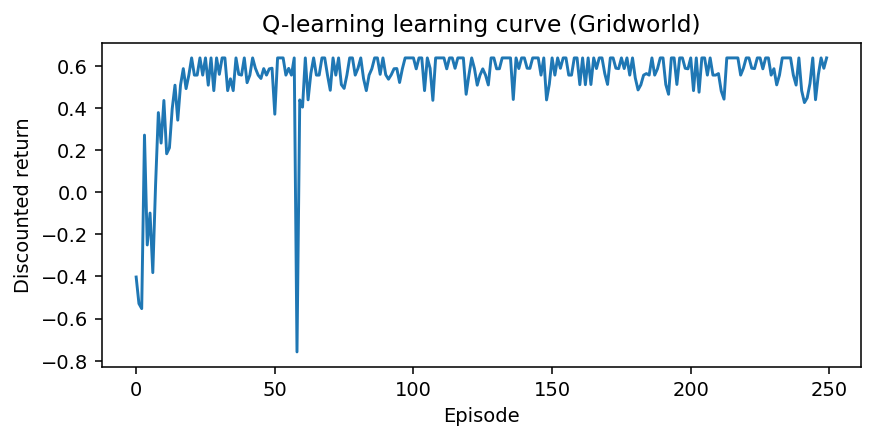

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,3))
plt.plot(episode_returns)
plt.xlabel("Episode")
plt.ylabel("Discounted return")
plt.title("Q-learning learning curve (Gridworld)")
plt.show()

### ۶.۱ اکتشاف مهم است: بررسی چند مقدار $\epsilon$

در اکتشاف epsilon-greedy، $\epsilon$ تعیین می‌کند چند درصد مواقع کنش تصادفی انتخاب شود.

- $\epsilon$ خیلی کوچک: ممکن است زود در سیاست نامطلوب گیر کنید.
- $\epsilon$ خیلی بزرگ: بیش از حد اکتشاف می‌کنید و همگرا شدن کند می‌شود.

چند مقدار $\epsilon$ را مقایسه می‌کنیم و روی ۵۰ اپیزود آخر آمار خلاصه محاسبه می‌کنیم.

In [19]:
# Epsilon sweep: effect of exploration rate
def run_qlearning(eps=0.15, episodes=200, alpha=0.25, gamma=0.95, seed=7):
    rng = np.random.default_rng(seed)
    Q = defaultdict(float)
    rets = []
    def eps_greedy(state):
        if rng.random() < eps:
            return rng.choice(actions)
        qs = [Q[(state,a)] for a in actions]
        return actions[int(np.argmax(qs))]
    for ep in range(episodes):
        s = start
        G = 0.0
        for t in range(200):
            a = eps_greedy(s)
            s2, r, done = step(s, a)
            G += (gamma**t) * r
            best_next = max(Q[(s2,a2)] for a2 in actions)
            Q[(s,a)] = Q[(s,a)] + alpha * (r + gamma*best_next - Q[(s,a)])
            s = s2
            if done:
                break
        rets.append(G)
    return np.array(rets)

eps_list = [0.05, 0.15, 0.30]
rows = []
curves = {}
for e in eps_list:
    rets = run_qlearning(eps=e)
    curves[e] = rets
    rows.append((e, round(rets[-50:].mean(), 3), round(rets[-50:].std(), 3)))

sweep = pd.DataFrame(rows, columns=["epsilon", "final50_mean_return", "final50_std"])
print("Exploration sweep (epsilon) — final 50-episode return stats:")
sweep

Exploration sweep (epsilon) — final 50-episode return stats:
 epsilon  final50_mean_return  final50_std
    0.05                0.598        0.204
    0.15                0.589        0.052
    0.30                0.444        0.264


,epsilon,final50_mean_return,final50_std
0,0.05,0.598,0.204
1,0.15,0.589,0.052
2,0.30,0.444,0.264


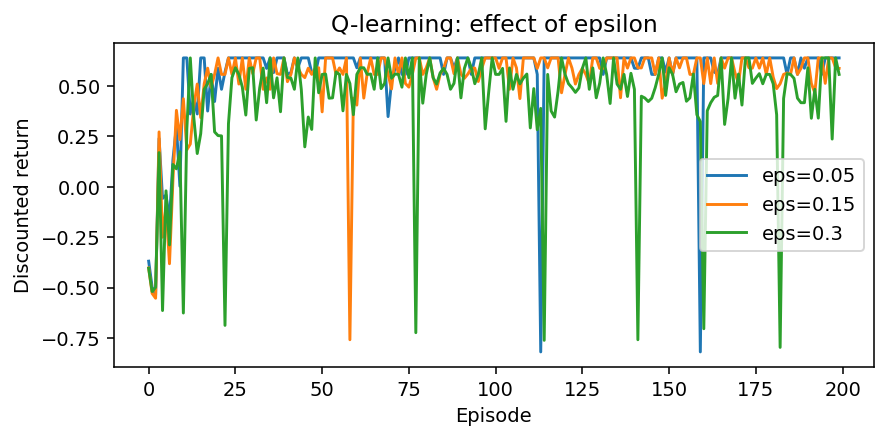

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,3))
for e, rets in curves.items():
    plt.plot(rets, label=f"eps={e}")
plt.xlabel("Episode")
plt.ylabel("Discounted return")
plt.title("Q-learning: effect of epsilon")
plt.legend()
plt.show()

## ۷. چگونه پارادایم مناسب را انتخاب کنیم (چک‌لیست)

از این چک‌لیست مهندسی استفاده کنید:
- چه نوع بازخوردی واقعاً قابل دستیابی است؟
- آیا می‌توانید قابل‌اعتماد ارزیابی کنید؟
- حالت‌های شکست محتمل چیست؟

جدول خلاصه و تمرین‌های انتهای نوت‌بوک را برای تثبیت مفاهیم ببینید.

## پیوست A — شهود عمیق‌تر (اختیاری اما توصیه‌شده)

این پیوست نکات مفهومی ظریفی را توضیح می‌دهد که معمولاً در ابتدای یادگیری ماشین باعث سردرگمی می‌شوند.

### A.1 تفاوت «نوع وظیفه» و «پارادایم یادگیری»
نوع وظیفه خروجی را تعیین می‌کند (طبقه‌بندی، رگرسیون، خوشه‌بندی و ...). پارادایم یادگیری نوع بازخورد و رژیم تولید داده را مشخص می‌کند (نظارتی، بدون‌ناظر، نیمه‌نظارتی، تقویتی).

### A.2 چرا وقتی برچسب داریم، یادگیری نظارتی معمولاً بهتر است؟
وقتی برچسب‌ها وجود دارند و با خروجی هدف هم‌راستا هستند، یادگیری نظارتی هم هدف‌گذاری مستقیم دارد و هم ارزیابی تمیز.

### A.3 یادگیری نیمه‌نظارتی «چه نیست»؟
نیمه‌نظارتی صرفاً پیش‌بینی دادهٔ بدون‌برچسب بعد از آموزش نیست. دادهٔ بدون‌برچسب باید روی هدف آموزش اثر بگذارد و مرز تصمیم را شکل دهد.

### A.4 RL رژیم داده‌ای متفاوتی دارد
داده در RL به سیاست وابسته است و ایستا نیست؛ اکتشاف ضروری است؛ و ارزیابی باید اپیزودهای آموزش و ارزیابی را جدا کند.

### A.5 پیش‌بینی در برابر علیت
دقت پیش‌بینی بالا لزوماً به معنای اعتبار علی نیست. سیستم‌های تصمیم‌محور باید ساختار علی و پیامدهای ناخواسته را در نظر بگیرند.

### A.6 همیشه از خط پایه شروع کنید
خط پایه‌ها خط لولهٔ شما را اعتبارسنجی می‌کنند، میزان سیگنال را نشان می‌دهند و معیار مقایسه برای پیچیدگی ایجاد می‌کنند.

---

## پیوست B — برگهٔ مرجع کوچک (یادآوری سریع)

### B.1 خروجی‌های رایج
- نظارتی: $\hat{y} = f(x)$
- بدون‌ناظر: برچسب خوشه $c_i$ یا امبدینگ $z_i$
- نیمه‌نظارتی: $\hat{y}$ بهتر با استفاده از دادهٔ برچسب‌دار و بدون‌برچسب
- RL: سیاست $\pi(a|s)$ یا ارزش-کنش $Q(s,a)$

### B.2 ارزیابی رایج
- طبقه‌بندی: دقت، precision/recall، F1، ROC-AUC (برای دودویی)
- رگرسیون: MAE، RMSE، $R^2$
- خوشه‌بندی: سیلوئت، Davies–Bouldin، پایداری، سودمندی پایین‌دستی
- RL: بازگشت میانگین، regret، قیود ایمنی، آزمون‌های استحکام

### B.3 دام‌های رایج (یک‌خطی)
- نشت داده: استفاده از اطلاعات آینده در ویژگی‌ها یا Fit کردن پیش‌پردازش روی دادهٔ آزمون
- بیش‌برازش: بهینه‌کردن انتخاب‌های زیاد با اعتبارسنجی کوچک
- هم‌بستگی‌های کاذب: میانبرهای «پیش‌بین اما غیرعلی» که زیر تغییر توزیع می‌شکنند
- هک پاداش: بیشینه‌کردن پاداش بدون رسیدن به هدف واقعی

### B.4 یک راهنمای کوتاه «چه زمانی از چه چیزی استفاده کنیم»
- وقتی برچسب دارید: نظارتی.
- وقتی برچسب کم است اما دادهٔ بدون‌برچسب زیاد و مشابه دارید: نیمه‌نظارتی.
- برای اکتشاف، بخش‌بندی و یادگیری بازنمایی: بدون‌ناظر.
- وقتی کنش‌ها حالت‌های آینده را تغییر می‌دهند و هدف بلندمدت است: RL.

---

## تمرین‌ها (پیشنهادی)

1. Iris: به‌جای رگرسیون لجستیک، SVM را امتحان کنید و ماتریس درهم‌ریختگی را مقایسه کنید.
2. Airports: برای $k \in \{2,3,4,5,6\}$ سیلوئت را حساب کنید و نمودار سیلوئت برحسب $k$ رسم کنید.
3. نیمه‌نظارتی: سهم برچسب‌دار را از ۵٪ تا ۳۰٪ تغییر دهید و دقت را رسم کنید.
4. RL: $\epsilon$ (اکتشاف) را تغییر دهید و پایداری منحنی یادگیری را مشاهده کنید.